#References
<ul>
<li>[Good pivot table reference](http://pandas.pydata.org/pandas-docs/stable/reshaping.html)</li>
<li>[Isohumolone reference](https://en.wikipedia.org/wiki/Isohumulone)</li>
<li>[Data Source](http://www.jeannicholashould.com/python-web-scraping-tutorial-for-craft-beers.html)</li>
</ul>

##Definitions
<br>
<dl>
<dt>International Bittering Units  (IBU)</dt>
<dd>A metric used to approximately quantify the bitterness of beer. An IBU is measured in parts-per-million (ppm) of [isohumolone](https://en.wikipedia.org/wiki/Isohumulone), the main chemical compound derived from hops that makes beer taste bitter. Isohumulone is created when the alpha acids in hops isomerize, or breakdown, in the boil. </dd>
<dt>Alcohol By Volume (ABV)</dt>
<dd>ABV is defined as the number of millilitres of pure ethanol present in 100 millilitres (3.4 US fl oz) of solution at 20 °C (68 °F). The number of millilitres of pure ethanol is the mass of the ethanol divided by its density at 20 °C, which is 0.78924 g/ml. The ABV standard is used worldwide. </dd>
<dt>Proof</dt>
<dd>Proof is a measure of the content of ethanol (alcohol) in an alcoholic beverage. The term was originally used in the United Kingdom and was equal to about 1.75 times the alcohol by volume (ABV). The UK now uses the ABV standard instead of alcohol proof. In the United States, alcohol proof is defined as twice the percentage of ABV.</dd>
<dt>Isohumulone</dt>
<dd>An alpha acid generated when hops breaksdown during boiling.</dd>
</dl>

#Analysis

##Import Libraries

There are four libraries used:

* pandas, provides dataframe capability
* numpy, provides numeric processing
* re, provides regular expressions
* nbextensions, provides twiddle features


In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from notebook.nbextensions import check_nbextension
check_nbextension('codefolding', user=True)
check_nbextension('codefolding/main.js', user=True)
ext_require_path = 'codefolding/main'
try:  # notebook >= 4.2.0
    from notebook.nbextensions import enable_nbextension
    enable_nbextension('notebook', ext_require_path)
except ImportError:
    from notebook.nbextensions import EnableNBExtensionApp
    EnableNBExtensionApp().enable_nbextension(ext_require_path)

#Beer Statistics


##Data Import

This section imports and parses the data.

In [26]:
filename = 'beers.csv'
#I will read my file into a list
clean_file = []
# Make sure file gets closed after being iterated
with open(filename, 'r') as f:
   # Read the file contents and generate a list for each line
   lines = f.readlines()[1:]
f.close()
#I will use the following regular expression to parse my data
pattern  = "^(.*),(.*),(.*),(.*),(.*),(.*),(.*),(.*)$"
replace  = "\1\t\2\t\3\t\4\t\5\t\6\t\7\t\8n"
for line in lines:
    match = re.search(pattern,line)  
    L = [match.group(i) for i in range(1,9)] 
    clean_file.append(L)
#The list is now parsed. I need to convert it into a dataframe
labels=["SEQ","ABV","IBU","ID","NAME","STYLE","BI","OZ"]    
beers = pd.DataFrame.from_records(clean_file,columns=labels)
beers.set_index('SEQ', inplace=True)
beers['NAME'] = beers['NAME'].map(lambda x: x.strip())
beers['BI'] = beers['BI'].astype(str)
beers['NAME'] = beers['NAME'].replace(to_replace=\
                '\(\d{4}\)', value='', regex=True)
beers['NAME'] = beers['NAME'].replace(to_replace=\
                '\(Current\)', value='', regex=True)
beers.drop_duplicates(['NAME'], keep='last',inplace=True)
beers.head(10).loc[:,["NAME",'STYLE','OZ']]

,NAME,STYLE,OZ
SEQ,,,
0,Pub Beer,American Pale Lager,12.0
1,Devil's Cup,American Pale Ale (APA),12.0
2,Rise of the Phoenix,American IPA,12.0
3,Sinister,American Double / Imperial IPA,12.0
4,Sex and Candy,American IPA,12.0
5,Black Exodus,Oatmeal Stout,12.0
6,Lake Street Express,American Pale Ale (APA),12.0
7,Foreman,American Porter,12.0
8,Jade,American Pale Ale (APA),12.0


##Read in List of Breweries

I have a list of craft brewers and the location (city and state). Here I import the brewer location data and merge the city and state columns into one.

In [27]:
breweries=pd.read_csv("breweries.csv",header=0)
breweries.columns=['BI',"BREWERY","CITY","STATE"]
breweries['CITY'] = breweries['CITY'].map(lambda x: x.strip())
breweries['STATE'] = breweries['STATE'].map(lambda x: x.strip())
breweries['BI'] = breweries['BI'].astype(str)
breweries['CITYSTATE']=breweries['CITY']+", "+breweries['STATE']
breweries.drop(['CITY','STATE'],axis=1,inplace=True)
breweries.head()

,BI,BREWERY,CITYSTATE
0,0,NorthGate Brewing,"Minneapolis, MN"
1,1,Against the Grain Brewery,"Louisville, KY"
2,2,Jack's Abby Craft Lagers,"Framingham, MA"
3,3,Mike Hess Brewing Company,"San Diego, CA"
4,4,Fort Point Beer Company,"San Francisco, CA"


##Clean Up Beer Database

The beer database is filled with duplicates. 

<ul>
<li>Same beer entered on different years</li>
<li>Same beer with lager add on the end of the name</li>
<li>Same beer listed as "(current)"</li>
</ul>

This code cleans up these defects. It also merges the beer and brewery data.

In [28]:
combined=beers.merge(breweries,how='inner',on="BI")
combined.drop(['BI'],axis=1,inplace=True)
combined.drop_duplicates(['NAME'], keep='last',inplace=True)
combined.to_csv("combined3", sep=',')
combined['NAME']=combined['NAME'].replace('Point \
                    Special Lager','Point Special')
combined['NAME'] = combined['NAME'].map(lambda x: x.strip())
combined.drop_duplicates(['NAME'], keep='last',inplace=True)
combined.to_csv("Crosscheck")

#Query the Database

##What Breweries Have The Greatest Number of Labels?
I have assumed that most craft brewers have a small number of labels, which turns out to be true. I was surprised to see that some breweries, however, have a large number of labels. I was stunned to see that Brewery Vivant had 55 different beer labels.

In [29]:
gg=combined[['BREWERY','NAME']]
g=gg.groupby('BREWERY')
g=g['NAME'].nunique().sort_values(ascending=False).head(10)
g.name='LABELS'
pd.DataFrame(g)

,LABELS
BREWERY,
Brewery Vivant,55
Sun King Brewing Company,34
Oskar Blues Brewery,23
Cigar City Brewing Company,23
Sixpoint Craft Ales,20
Upslope Brewing Company,18
Bonfire Brewing Company,17
Great Crescent Brewery,16
Sockeye Brewing Company,15


##Beers with the Highest ABV?

In the US, the alcohol content of hard liquor is usually quoted in terms of proof. Beer is handled differently &ndash; its alcohol content is specified in terms of percentage alcohol by volume, ABV. I am used to seeing commercial brews with ABV values of 3% to 4%. I was a bit surprised to see the wide range of ABV values for craft brews. The table below shows the top ten craft brews in terms of ABV.

In [30]:
abv=combined[["NAME","ABV"]].sort_values(["ABV",\
        "NAME"],ascending=[False,True]).head(10)
abv1=abv.set_index("NAME")
abv1.index.name="Beer Name"
abv1['ABV']=abv1["ABV"].apply(lambda x: float(x)*\
                    100).apply(lambda x: str(x)+"%")
abv1.columns=["Alcohol By Volume"]
abv1

,Alcohol By Volume
Beer Name,
Lee Hill Series Vol. 5 - Belgian Style Quadrupel Ale,12.8%
London Balling,12.5%
Csar,12.0%
Lee Hill Series Vol. 4 - Manhattan Style Rye Ale,10.4%
4Beans,10.0%
3Beans,9.9%
Axe Head Malt Liquor,9.9%
BLAKKR,9.9%
Barrel Aged Seven Devils Imperial Stout,9.9%


##ABV Histogram

To get a feel for the distribution of beer ABVs, I generated the histogram shown below.

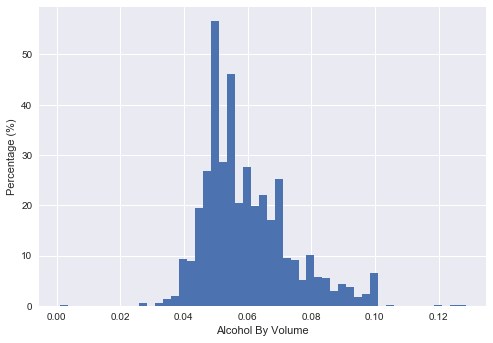

In [31]:
import matplotlib.pyplot as plt
abv=combined[["NAME","ABV"]].sort_values(["ABV",\
                   "NAME"],ascending=[False,True])
sns.set()
abv['ABV'].replace('', np.nan, inplace=True)
abv.dropna(subset=['ABV'], inplace=True)
a=abv["ABV"].apply(lambda x: float(x))
binwidth=0.0025
_ = plt.hist(a,bins=np.arange(min(a), max(a) + binwidth, \
                              binwidth),normed=True)
_ = plt.xlabel('Alcohol By Volume')
_ = plt.ylabel('Percentage (%)')
plt.show()

##Beewarm Plot

Another way to show the distribution of ABV values is with a beeswarm plot, which I show below. Note that the beeswarm plot takes a lot of time to plot, so I subsetted the ABV data to speed things up.

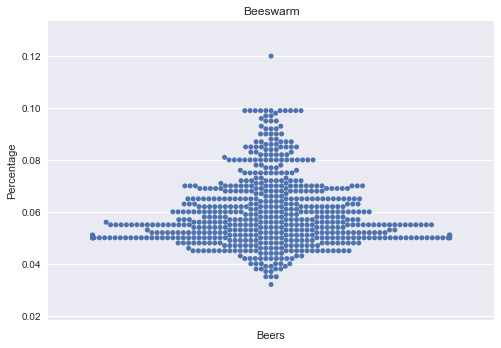

In [32]:
sns.set()
x = [""]*len(a)
x = pd.Series(x)
zz=x.to_frame().join(a.to_frame())
zz.dropna(inplace=True)
zzz=zz
zz=zz.iloc[0:2000:3,:]
zz.columns=['BEER','ABV']
_ = sns.swarmplot(x='BEER',y='ABV',data=zz)
_ = plt.xlabel('Beers')
_ = plt.ylabel('Percentage')
_ = plt.title('Beeswarm')
plt.show()

##Violin Plot

Another approach to illustrating the ABV values is the violin plot. These plots can be extremely sophisticated. For this data, I will only add quartile lines &ndash; just remember that there are an enormous number of options for these plots. 

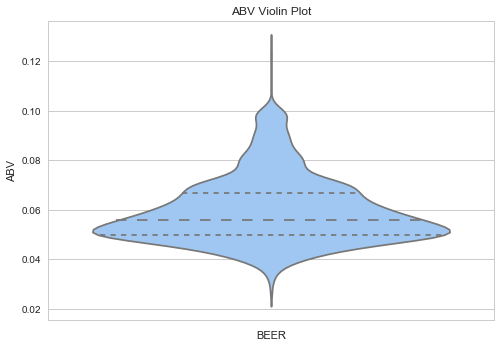

In [33]:
zzz.columns=['BEER','ABV']
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x="BEER", y="ABV", inner='quart',data=zzz,split=True)
plt.title('ABV Violin Plot')
plt.show()

##What Cities Have the Most Craft Brewers?

When I think of craft beers, I normally think of places like Bend, OR. The table below shows that craft breweries are popular in the places you would expect.

In [34]:
gg=combined[['CITYSTATE','BREWERY']]
g=gg.groupby('CITYSTATE')
g1=g['BREWERY'].nunique().sort_values(ascending=False)\
                   .head(10) #Generates a Pandas series
g1.name='BREWERY_NUM'
pd.DataFrame(g1) #Converts a Pandas series to a 
                 #dataframe for pretty printing 

,BREWERY_NUM
CITYSTATE,
"Portland, OR",11
"Chicago, IL",9
"Seattle, WA",9
"Boulder, CO",9
"Austin, TX",8
"Denver, CO",8
"San Diego, CA",8
"Portland, ME",6
"Bend, OR",6


##Number of Distinct Beer Varieties?

I am always amazed when I see the number of different beer varieties. As yo can see in the following tables, IPAs are very popular.

In [35]:
styles=combined["STYLE"].value_counts(normalize=False).head(10)
styles.name='Style Labels'
styles.index.name='Beer Style'
pd.DataFrame(styles)

,Style Labels
Beer Style,
American IPA,380
American Pale Ale (APA),212
American Amber / Red Ale,118
American Blonde Ale,97
American Double / Imperial IPA,94
American Pale Wheat Ale,71
American Porter,63
American Brown Ale,63
Saison / Farmhouse Ale,50


##Which Beers are the Most Bitter?

While the % alcohol level of the various beers are well known, the bitterness levels are less well known. However, a number of beers do specify their bitterness, and we can generate a table of these values with ease.

Here is the label of the record holding bitter beer.



[Bitterness Link](https://en.wikipedia.org/wiki/Beer_measurement#Bitterness)

In [36]:
combined['IBU'].replace('', np.nan, inplace=True)
combined.dropna(subset=['IBU'], inplace=True)
combined['IBU'] = combined['IBU'].astype('float64') 
combined.sort_values(by=['IBU'],ascending=False,axis=0,inplace=True)
bitter=combined.set_index(['NAME'])['IBU']
bit_beer=bitter.head(10)
bit_beer.index.name="BITTER BEER"
bit_beer.name='IBU (PPM Isohumulone)'
pd.DataFrame(bit_beer)

,IBU (PPM Isohumulone)
BITTER BEER,
Bitter Bitch Imperial IPA,138.0
Troopers Alley IPA,135.0
Dead-Eye DIPA,130.0
Bay of Bengal Double IPA,126.0
Heady Topper,120.0
Abrasive Ale,120.0
More Cowbell,118.0
Hop A-Peel,115.0
Overlord Imperial IPA,115.0
